In [0]:
# remove or comment this cell if tensorflow 2.0 is released
# installing tensorflow 2.0 beta with gpu 
! pip install tensorflow-gpu==2.0.0-beta0

# Prefix
Purpose of this notebook is to explored the concept of the CNN or Convolutional Neural Network archtecture using keras and tensorflow. 

In this notebook we going to use the famous Kaggle Dog vs Cat dataset, https://www.kaggle.com/c/dogs-vs-cats.

This was a challenge on building a classifier amid at world's best Machine Learning and AI Practitioner, but with the quick advance in this technology, you can build a simple CNN with in minutes. This is a great exerice in looking at large dataset, downloading and prepare for training, and preprocessing of data.

Warning there is some data that was corrupted, but it would not be an issue or impact for the model.

# Step - 1: Explore the Data
Starting by downloading the dataset of a .zip containing 2,000 image of the cats and dogs, and extract it in the /tmp floder.

Note: The actual dataset for the kaggle challenge contains 25,000 images, here we are using a subset of 2,000 out of the 25,000 image for testing.

In [0]:
if not os.path.exists('/tmp/cats_and_dogs_filtered.zip'):
  !wget --no-check-certificate \
    "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip" \
    -O "/tmp/cats_and_dogs_filtered.zip"
else:
  print('.zip file already exists')

--2019-06-11 00:54:07--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  93.7MB/s    in 0.7s    

2019-06-11 00:54:08 (93.7 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
# this using the os and zipfile python library to give your access to the files
import os, zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'  # location of the zip
zip_ref = zipfile.ZipFile(local_zip, 'r')        # set permission to read zip
zip_ref.extractall('/tmp')                     # using the extractall function to extract the zip in the /tmp folder
zip_ref.close()                                # close of the zip

After extraction of the .zip file, when you look at the /tmp folder in this ipython notebook instance, you would able to find the cats_and_dogs_filtered folder. Inside this folder there should contain train and validation folder. Within those folders there should contain cats folder and dogs folder both containing the images relative to the folder's name.

We don't have to label the images inside either the cats and dogs folder, because we will be using the ImageGenerator to simplify this process.

In [0]:
# Defining the path to the correct folders
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')

# paths for training examples
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# paths for validation examples
valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')

Now let's see what the file in the folder look like.

In [0]:
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)

# print the first 10 file name in each folder
print(train_cats_fnames[:10])
print(train_dogs_fnames[:10])

['cat.81.jpg', 'cat.429.jpg', 'cat.553.jpg', 'cat.195.jpg', 'cat.617.jpg', 'cat.389.jpg', 'cat.522.jpg', 'cat.65.jpg', 'cat.363.jpg', 'cat.991.jpg']
['dog.487.jpg', 'dog.758.jpg', 'dog.8.jpg', 'dog.389.jpg', 'dog.274.jpg', 'dog.552.jpg', 'dog.365.jpg', 'dog.75.jpg', 'dog.154.jpg', 'dog.131.jpg']


Now let's see how many files are in each folder.

In [0]:
print("Total training cat images  :", len(os.listdir(train_cats_dir)))
print("Total training dog images  :", len(os.listdir(train_dogs_dir)))
print("Total validation cat images:", len(os.listdir(valid_cats_dir)))
print("Total validation dog images:", len(os.listdir(valid_dogs_dir)))

Total training cat images  : 1000
Total training dog images  : 1000
Total validation cat images: 500
Total validation dog images: 500


The training set containing a total of 2000 images with 1000 cats images and 1000 dogs images. The validation set containing a total of 1000 images with 500 cats images and 500 dogs images.

Now, let's have a visualization of help would each of the images look like.

In [0]:
# ploting the images with matplotlib for an idea of how the images are different
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

# function for selecting random images from the directory and return a python list
def select_random(_dir, n):
  _list = [os.path.join(_dir, fname) for fname in os.listdir(_dir)]
  return list(np.random.choice(_list, size=n, replace=False))

# creating a plot with rows=4, cols=4 with randomly selected cats and dogs images
def ploting_images(cats_dir, dogs_dir, rows=4, cols=4):
  dimension = rows*cols
  display_img_leng = int(dimension/2)
  print('Displaying {} image of cats and dogs'.format(display_img_leng))
  
  fig = plt.gcf()
  fig.set_size_inches(cols*4, rows*4)
  
  cat_images = select_random(cats_dir, display_img_leng)
  dog_images = select_random(dogs_dir, display_img_leng)
  
  for i, img_path in enumerate(cat_images+dog_images):
    # Set up subplot
    sp = plt.subplot(rows, cols, i+1)
    sp.axis('off') # Don't show gridlines
    
    img = mpimg.imread(img_path)
    plt.imshow(img)
  
  plt.show()

Displaying 8 image of cats and dogs


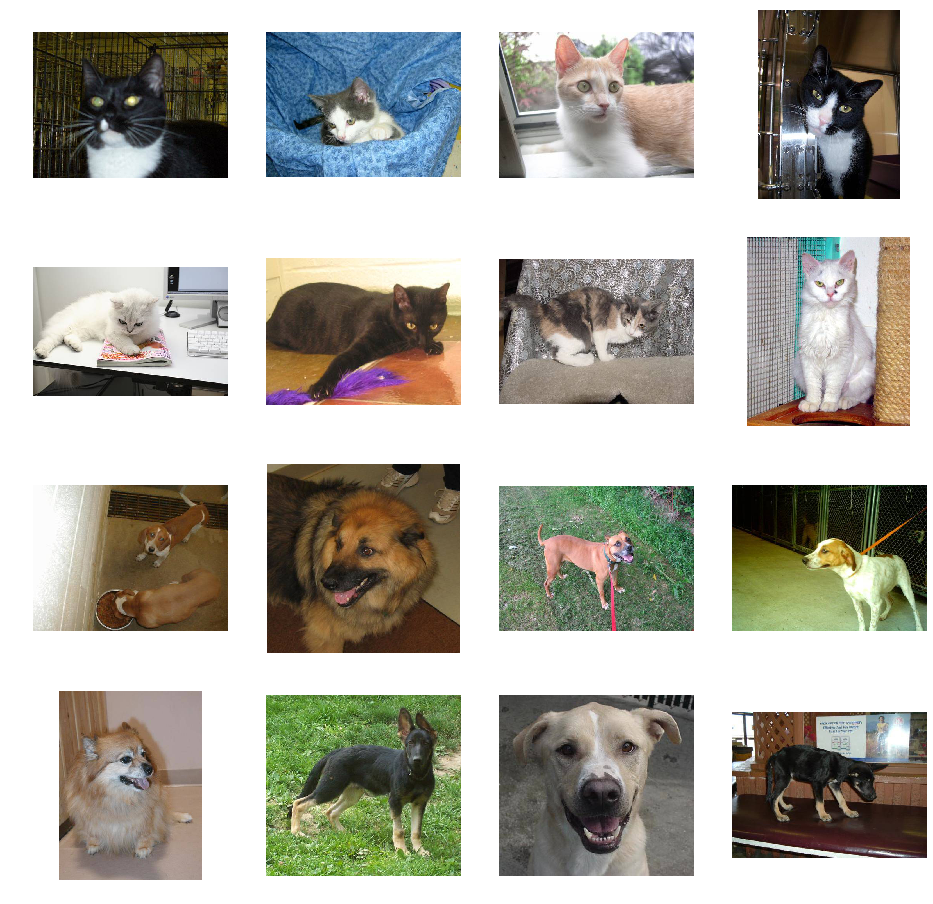

In [0]:
# you can run this cell multiply times to see different images
# you can also change the number of rows and columns to display more or less images
ploting_images(train_cats_dir, train_dogs_dir)

Now, you have a understanding of how the images look like, it is time to build the simple CNN with keras.

# Step - 2: Build the Model
In this notebook we will be using the tensorflow framework with the Keras high level api.

We will be resizing the images to 150x150 pixels using the ImageDataGenerator from tensorflow.keras.preprocessing.image to preprocess our datas.

In [0]:
# importing all methods we going to be using
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
_input = Input(shape=(150, 150, 3))
x = Conv2D(16, (3,3), activation='relu')(_input)
x = MaxPooling2D(2,2)(x)
x = Conv2D(32, (3,3), activation='relu')(x)
x = MaxPooling2D(2,2)(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(2,2)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(_input, x)

In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0     

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

### Data Preprocessing

In [0]:
# all images is resizing to 1./255.
train_datagen = ImageDataGenerator(rescale=1./255.)
valid_datagen = ImageDataGenerator(rescale=1./255.)

# flow training image in batch of 20 using the ImageDataGenerator
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150,150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Training the model

In [0]:
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    steps_per_epoch=100,
                    epochs=15,
                    validation_steps=20,
                    verbose=2)

Epoch 1/15


W0611 00:55:34.729483 140710670182272 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100/100 - 10s - loss: 0.7734 - acc: 0.5185 - val_loss: 0.6887 - val_acc: 0.5075
Epoch 2/15
100/100 - 7s - loss: 0.6431 - acc: 0.6235 - val_loss: 0.6046 - val_acc: 0.7075
Epoch 3/15
100/100 - 7s - loss: 0.5867 - acc: 0.6940 - val_loss: 0.6695 - val_acc: 0.6475
Epoch 4/15
100/100 - 7s - loss: 0.5096 - acc: 0.7470 - val_loss: 0.5952 - val_acc: 0.7125
Epoch 5/15
100/100 - 7s - loss: 0.4301 - acc: 0.7970 - val_loss: 0.6560 - val_acc: 0.6550
Epoch 6/15
100/100 - 7s - loss: 0.3291 - acc: 0.8555 - val_loss: 0.7104 - val_acc: 0.6950
Epoch 7/15
100/100 - 7s - loss: 0.2509 - acc: 0.8925 - val_loss: 0.8093 - val_acc: 0.6950
Epoch 8/15
100/100 - 7s - loss: 0.1656 - acc: 0.9350 - val_loss: 0.9037 - val_acc: 0.6975
Epoch 9/15
100/100 - 7s - loss: 0.1035 - acc: 0.9625 - val_loss: 0.9979 - val_acc: 0.6950
Epoch 10/15
100/100 - 7s - loss: 0.0739 - acc: 0.9765 - val_loss: 1.3323 - val_acc: 0.7100
Epoch 11/15
100/100 - 7s - loss: 0.0444 - acc: 0.9855 - val_loss: 1.4279 - val_acc: 0.7025
Epoch 12/15
100/10

### Testing the Model

In [0]:
# pick random files from cat and dog validation sets
def predict_random_image(model, cats_dir, dogs_dir, n_images=8):
  from tensorflow.keras.preprocessing import image
  
  cat_images = select_random(cats_dir, n_images)
  dog_images = select_random(dogs_dir, n_images)
  images = cat_images+dog_images

  array = []
  for path in images:
    arr = [path, path.split('/')[-2][:-1]]
    array.append(arr)
    
  for path, label in array:
    img = image.load_img(path, target_size=(150,150))
  
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])

    classes = model.predict(images)

    predict = 'dog' if classes[0] > 0 else 'cat'

    if predict == label:
      print("model prediction is correct, image: {} is a {}".format(path.split('/')[-1], predict))
    else:
      print('model predcition is wrong, image: {} is not a {}'.format(path.split('/')[-1], predict))

In [0]:
predict_random_image(model, valid_cats_dir, valid_dogs_dir)

model prediction is correct, image: cat.2313.jpg is a cat
model predcition is wrong, image: cat.2434.jpg is not a dog
model predcition is wrong, image: cat.2078.jpg is not a dog
model prediction is correct, image: cat.2485.jpg is a cat
model predcition is wrong, image: cat.2042.jpg is not a dog
model predcition is wrong, image: cat.2264.jpg is not a dog
model prediction is correct, image: cat.2377.jpg is a cat
model predcition is wrong, image: cat.2394.jpg is not a dog
model prediction is correct, image: dog.2038.jpg is a dog
model prediction is correct, image: dog.2377.jpg is a dog
model predcition is wrong, image: dog.2317.jpg is not a cat
model predcition is wrong, image: dog.2068.jpg is not a cat
model prediction is correct, image: dog.2275.jpg is a dog
model predcition is wrong, image: dog.2392.jpg is not a cat
model prediction is correct, image: dog.2167.jpg is a dog
model prediction is correct, image: dog.2261.jpg is a dog


In [0]:
# # if you would to upload images to test the model uncomment and run this cell
# from google.colab import files

# uploaded=files.upload()

# for fn in uploaded.keys():
  
#   # predicting the image
#   path='/content/' + fn
#   img=image.load_img(path, target_size=(150, 150))

#   x=image.img_to_array(img)
#   x=np.expand_dims(x, axis=0)
#   images = np.vstack([x])

#   classes = model.predict(images, batch_size=10)

#   print(classes[0])

#   if classes[0]>0:
#     print(fn + " is a dog")

#   else:
#     print(fn + " is a cat")

# Step - 3: Evaluating Accuracy and loss for the Model
Ploting the training and validation loss collected during training.

In [0]:
# method for ploting the training and validation history
def plot_history(history):
  # retreiving the list of result from training
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  # ploting the training and validation acc
  plt.plot(epochs, acc, label='training acc')
  plt.plot(epochs, val_acc, label='validation acc')
  plt.title('Training and Validation Accuracy')
  plt.legend()
  plt.figure()

  # ploting the training and validation loss
  plt.plot(epochs, loss, label='training loss')
  plt.plot(epochs, val_loss, label='validation loss')
  plt.title('Training and Validation Loss')
  plt.legend()

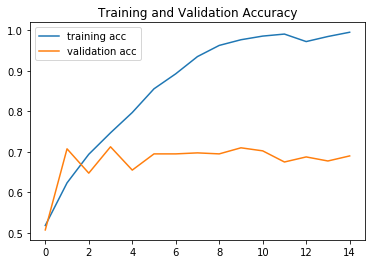

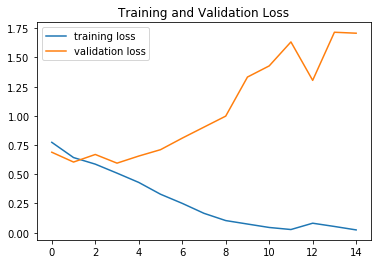

In [0]:
# retreiving the list of result from training
plot_history(history)

As you can see the validation accuracy stay around 70% after 2 epochs, and the training accuracy went higher. As a result the model is overfitting, this is probabily cost by the small dataset. To fix this we could train it on the full dataset.

# Step - 4: Visualizing Intermediate Representations
To get a feel for what the convnet has learned, one fun thing to do is to visualizing how an input get tranformed as it geos through the convnet. 

In [0]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# new model outputs the input as intermediate representations for all layers in
# the previous model after the first
successive_outputs = [layer.output for layer in model.layers[1:]]

visualization_model = Model(inputs=model.input, outputs=successive_outputs)

# get a random images of either cats and dogs
rand_cat_images = select_random(train_cats_dir, 1)
rand_dog_images = select_random(train_dogs_dir, 1)
rand_img = np.random.choice(rand_cat_images+rand_dog_images)
print(rand_img)

# load and resizing the image to (150x150) pixels
img = load_img(rand_img, target_size=(150, 150))
# change the image to numpy array and reshaping it to (1, 150, 150, 3)
x = img_to_array(img)
x = x.reshape((1,)+x.shape)
# scale the image to 1./255.
x /= 255.

# run the image through the intermediate network, thus obtaining all intermediate
# representations for this image
successive_feature_maps = visualization_model.predict(x)

# get the name of each layer for plotting
layer_names = [layer.name for layer in model.layers]

/tmp/cats_and_dogs_filtered/train/dogs/dog.271.jpg


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


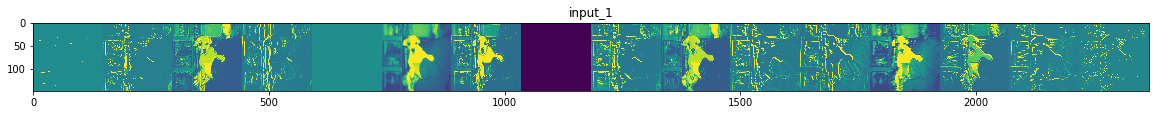

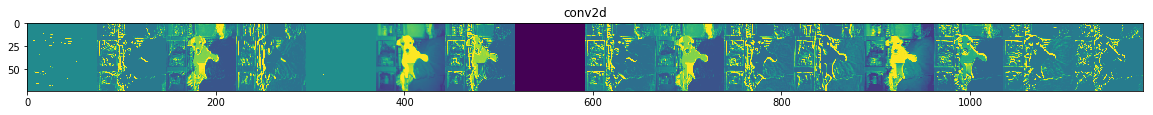

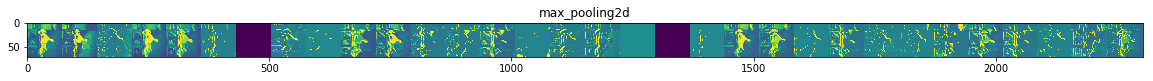

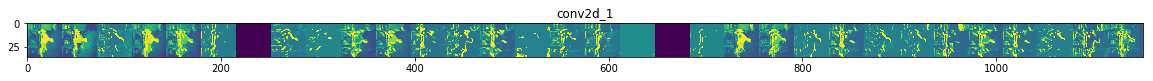

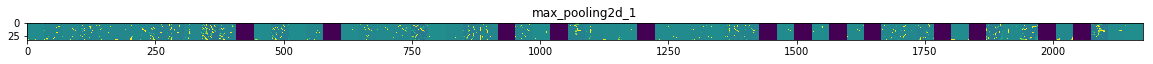

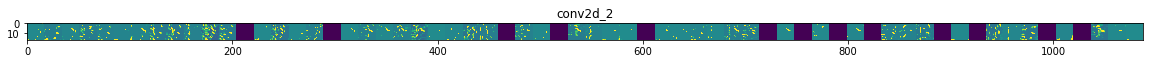

In [0]:
# time to plot the layers
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # just do this for the conv / maxpool not the fully connected layers
    n_features = feature_map.shape[-1]
    size = feature_map.shape[1]
    
    # tile the images
    display_grid = np.zeros((size, size * n_features))
    
    # postprocess the features to be visually palatable
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # tile each feature into horizontal gird
      display_grid[:, i*size:(i+1)*size] = x
    
    # display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale*n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Step - 5: Training the Model with the Full Dataset
Now we are ready to train the model with the complete kaggle dataset.

In [0]:
# first downloading and extract the kaggle dataset
if not os.path.exists('/tmp/cats-and-dogs.zip'):
  !wget --no-check-certificate \
      "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
      -O "/tmp/cats-and-dogs.zip"

  local_zip = '/tmp/cats-and-dogs.zip'
  zip_ref = zipfile.ZipFile(local_zip, 'r')
  zip_ref.extractall('/tmp')
  zip_ref.close()
else:
  print('dataset already downloaded and extracted')

--2019-06-11 00:58:37--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.52.75.45, 2001:418:1401:482::e59, 2001:418:1401:48f::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.52.75.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M  19.9MB/s    in 42s     

2019-06-11 00:59:20 (18.8 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



The full kaggle cats vs dogs dataset has not been split into training and testing, so we have to do it ourself.

In [0]:
# First, trying to create the necessary folders needed for the training and testing set
#import shutil
#shutil.rmtree('/tmp/cats-v-dogs')

try:
  dir_dic = {'cats-v-dogs': {
  'training': ['cats', 'dogs'],
  'testing' : ['cats', 'dogs']
  }}
  for main_dir in dir_dic.keys():
    main_path = '/tmp/' + main_dir+'/'
    if not os.path.exists(main_path):
      os.mkdir(main_path)
    else:
      print(main_path, 'already exists')
    for sub_dir in dir_dic[main_dir].keys():
      sub_path = main_path+sub_dir+'/'
      if not os.path.exists(sub_path):
        os.mkdir(sub_path)
      else:
        print(sub_path, 'already exists')
      for ssub_dir in dir_dic[main_dir][sub_dir]:
        ssub_path = sub_path+ssub_dir
        if not os.path.exists(ssub_path):
          os.mkdir(ssub_path)
        else:
          print(ssub_path, 'already exists')
except OSError as e:
  print(e)
  pass

In [0]:
# method for split the data and then copy to the proper folder
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  from shutil import copyfile
  
  source_list = []
  for file in os.listdir(SOURCE):
    if os.path.getsize(SOURCE+file) > 0.:
      source_list.append(file)
    else:
      print(file, 'is zero length, so will be ignore')
      
  # splitting the list from a shuffled data set
  shuffle_list = random.sample(source_list, len(source_list))
  split = int(len(shuffle_list)*SPLIT_SIZE)
  
  for i, file in enumerate(shuffle_list):
    if i < split:
      copyfile(SOURCE+file, TRAINING+file)
    else:
      copyfile(SOURCE+file, TESTING+file)

In [0]:
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so will be ignore
11702.jpg is zero length, so will be ignore


After spliting the data, we have to preprocess the data for training

In [0]:
TRAINING_DIR = '/tmp/cats-v-dogs/training'
train_datagen = ImageDataGenerator(rescale=1./255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    target_size=(150,150),
                                                    class_mode='binary')

VALIDATION_DIR = '/tmp/cats-v-dogs/testing'
validation_datagen = ImageDataGenerator(rescale=1./255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              target_size=(150,150),
                                                              class_mode='binary')

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


### Retraining the model with the full dataset

In [0]:
full_history = model.fit(train_generator,
                         validation_data=validation_generator,
                         batch_size=100,
                         epochs=15,
                         verbose=1)

Epoch 1/15
 31/225 [===>..........................] - ETA: 1:03 - loss: 0.8453 - acc: 0.6804

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 209715200 bytes but only got 0. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 52428800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6468665344 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 7027. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expe

 32/225 [===>..........................] - ETA: 1:03 - loss: 0.8413 - acc: 0.6776

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but 

101/225 [============>.................] - ETA: 39s - loss: 0.6444 - acc: 0.7071

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404094976 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404619264 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 425459712 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecti

119/225 [==============>...............] - ETA: 34s - loss: 0.6274 - acc: 0.7135

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18350080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


196/225 [=========================>....] - ETA: 9s - loss: 0.5752 - acc: 0.7335

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307363840 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307888128 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 328728576 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385474 bytes but only got 5357. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expe

216/225 [===========================>..] - ETA: 2s - loss: 0.5675 - acc: 0.7362

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 4951. Skipping tag 51
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293339136 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293863424 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expect

218/225 [============================>.] - ETA: 2s - loss: 0.5666 - acc: 0.7364

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262146 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262151 bytes but only got 0. Skipping tag 56
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


225/225 [==============================] - 81s 360ms/step - loss: 0.5626 - acc: 0.7383 - val_loss: 0.4698 - val_acc: 0.7828
Epoch 2/15
225/225 [==============================] - 76s 338ms/step - loss: 0.4066 - acc: 0.8159 - val_loss: 0.4397 - val_acc: 0.8000
Epoch 3/15
225/225 [==============================] - 76s 336ms/step - loss: 0.3096 - acc: 0.8661 - val_loss: 0.4238 - val_acc: 0.8152
Epoch 4/15
225/225 [==============================] - 76s 338ms/step - loss: 0.2061 - acc: 0.9185 - val_loss: 0.4606 - val_acc: 0.8100
Epoch 5/15
225/225 [==============================] - 75s 334ms/step - loss: 0.1126 - acc: 0.9608 - val_loss: 0.5141 - val_acc: 0.8124
Epoch 6/15
225/225 [==============================] - 75s 335ms/step - loss: 0.0610 - acc: 0.9804 - val_loss: 0.6308 - val_acc: 0.8152
Epoch 7/15
225/225 [==============================] - 75s 334ms/step - loss: 0.0374 - acc: 0.9896 - val_loss: 0.7621 - val_acc: 0.8040
Epoch 8/15
225/225 [==============================] - 76s 336ms/st

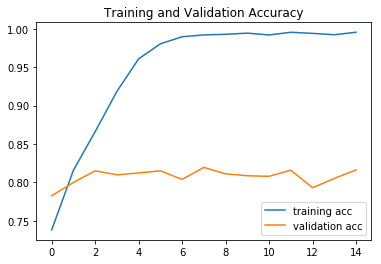

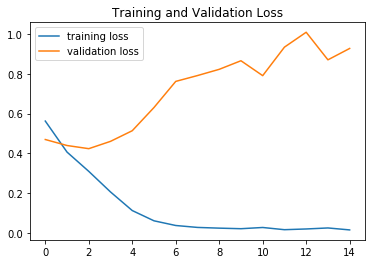

In [0]:
plot_history(full_history)

As you can see the validation accuracy is lower then the training accuracy while the validation loss is increasing, this show the model is overfitting after 2 epochs.

In [0]:
# delete everything inside the /tmp directory
def delete_tmp_files():
  import os, shutil
  for fname in os.listdir('/tmp'):
    path = '/tmp/'+fname
    if os.path.isdir(path):
      shutil.rmtree(path)
    else:
      os.remove(path)

# uncomments this to delete files and directory in the /tmp directory 
# delete_tmp_files()